# Import Library

In [1]:
pip install yfinance


In [2]:
# Load data
import yfinance as yf
import pandas as pd
import numpy as np
import os
from datetime import datetime
import time

#EDA
from statsmodels.tsa.seasonal import seasonal_decompose

# Data preparation
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler

# Modelling
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Inference & save model
import json
from datetime import datetime
import tensorflow as tf
import joblib



# Load data

In [3]:
def get_eurusd_data(start_date='2015-01-01', end_date=None, csv_path='eurusd_data.csv', force_download=False, delay=5):
    if end_date is None:
        end_date = datetime.today().strftime('%Y-%m-%d')

    if not force_download and os.path.exists(csv_path):
        print(f"Membaca data dari cache: {csv_path}")
        data = pd.read_csv(csv_path, index_col=0, parse_dates=True)
    else:
        print(f"Mengunduh data EUR/USD dari Yahoo Finance: {start_date} sampai {end_date}")
        time.sleep(delay)
        data = yf.download('EURUSD=X', start=start_date, end=end_date)

        # Ambil hanya 5 kolom yang diinginkan
        columns_to_keep = ['Close', 'High', 'Low', 'Open', 'Volume']
        data = data[columns_to_keep]

        # Ganti nama kolom sesuai urutan (agar mudah pada data preparation)
        data.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

        data.to_csv(csv_path)
        print(f"Data disimpan ke {csv_path}")

    return data

data = get_eurusd_data(end_date=None)  # end_date=None untuk hari ini


Membaca data dari cache: eurusd_data.csv


# EDA

## Cek missing value & duplikat

In [5]:
data.isnull().sum()

,0
Close,0
High,0
Low,0
Open,0
Volume,0


In [6]:
data.duplicated().sum()

np.int64(0)

## Meneliti 5 data terakhir

In [7]:
data.tail(5)

,Close,High,Low,Open,Volume
Date,,,,,
2025-06-02,1.135332,1.144911,1.135589,1.135332,0
2025-06-03,1.145344,1.145515,1.136764,1.145344,0
2025-06-04,1.138446,1.143458,1.135938,1.138446,0
2025-06-05,1.142204,1.149425,1.140615,1.142204,0
2025-06-06,1.145383,1.145869,1.137230,1.145383,0


## Meneliti dimensi dataset

In [8]:
print("Dimensi dataset:", data.shape)

Dimensi dataset: (2716, 5)


## Meneliti nilai

In [9]:
data.describe()

,Close,High,Low,Open,Volume
count,2716.000000,2716.000000,2716.000000,2716.000000,2716.0
mean,1.117651,1.121248,1.114018,1.117632,0.0
std,0.052363,0.052139,0.052524,0.052354,0.0
min,0.959619,0.967006,0.954016,0.959619,0.0
25%,1.083397,1.086714,1.080307,1.083432,0.0
50%,1.114020,1.117701,1.110578,1.114150,0.0
75%,1.150758,1.154214,1.146129,1.150583,0.0
max,1.251001,1.255808,1.245051,1.251267,0.0


### Insight :    
- Nilai volume 0, karena pasangan USD sering tidak ditampilkan data nya oleh beberapa pihak, salah satunya platform sumber kami yaitu Yahoo Finance
- Volume akan dihapus karena tidak memiliki pengaruh pada time series, karena tidak ada datanya.

## Visualisasi Tren Harga

<Axes: title={'center': 'USD/JPY Closing Price'}, xlabel='Date'>

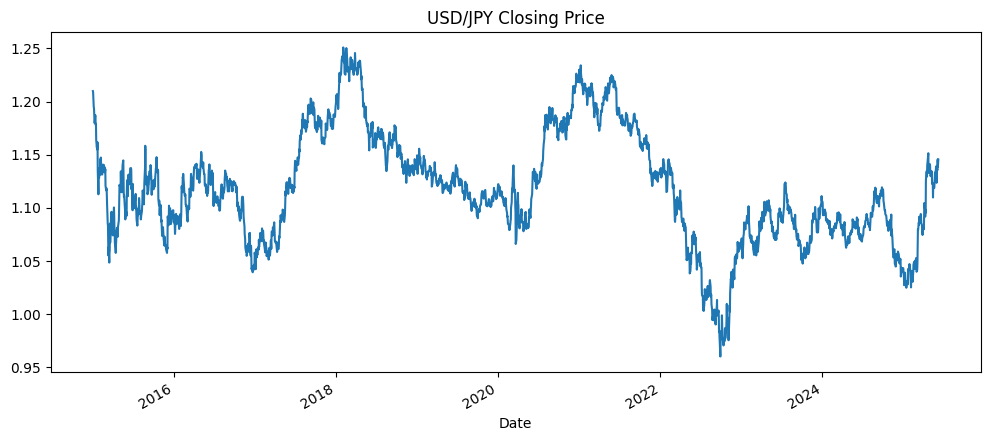

In [10]:
data['Close'].plot(figsize=(12, 5), title='USD/JPY Closing Price')

## Seasonality & Trend

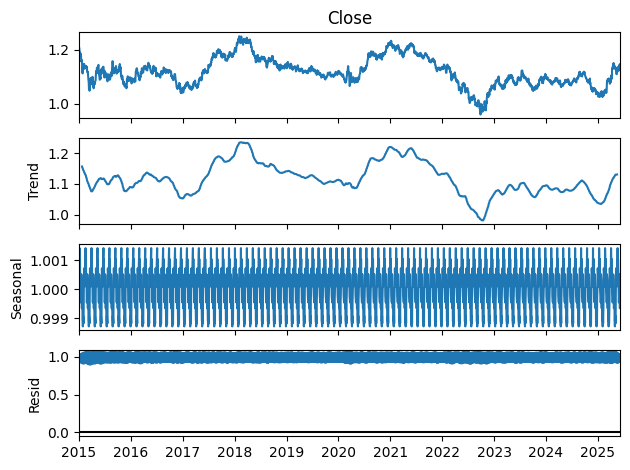

In [11]:
result = seasonal_decompose(data['Close'], model='multiplicative', period=30)
result.plot();

### Insight :     
- EUR/USD memiliki fluktuasi tren jangka panjang
- Ada kenaikan signifikan antara 2017–2018 dan 2020–2021.
- Fluktuasi seasonal cukup kecil dalam skala.
- Setelah 2021, terjadi penurunan tren yang cukup tajam hingga 2022. Kemungkinan besar karena efek pandemi corona
- Terdapat fase tren naik dan turun yang panjang, cocok untuk digunakan dalam strategi long-term trading atau hedging.

## Boxplot

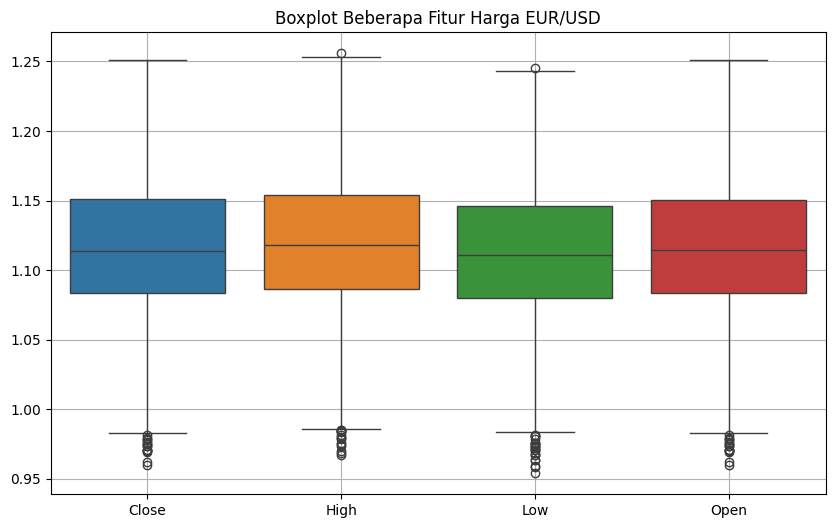

In [12]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['Close', 'High', 'Low', 'Open']])
plt.title("Boxplot Beberapa Fitur Harga EUR/USD")
plt.grid(True)
plt.show()

### Insight :
- Distribusi merata, ada beberapa outlier namun masih bisa di tolerisasi
- Outlier tersebut bisa saja high spike pada momentum tertentu dengan faktor fundamental, teknikal, dan sentimen pasar

# Data Preprocessing

In [13]:
# 1. Memastikan index dataframe adalah date
print(data.index)

DatetimeIndex(['2015-01-01', '2015-01-02', '2015-01-05', '2015-01-06',
               '2015-01-07', '2015-01-08', '2015-01-09', '2015-01-12',
               '2015-01-13', '2015-01-14',
               ...
               '2025-05-26', '2025-05-27', '2025-05-28', '2025-05-29',
               '2025-05-30', '2025-06-02', '2025-06-03', '2025-06-04',
               '2025-06-05', '2025-06-06'],
              dtype='datetime64[ns]', name='Date', length=2716, freq=None)


In [14]:
# 2. Menghapus kolom volume
data.drop(columns=['Volume'], inplace=True)

# 3. Hitung perubahan harga harian (Price Change)
data['Price_Change'] = data['Close'].diff().fillna(0)

# 4. Klasifikasi perubahan harga (Price Range Class)
def classify_price_range(change):
    if change <= -0.01:
        return 'turunjauh'
    elif change <= -0.001:
        return 'turundekat'
    elif change > 0.01:
        return 'naikjauh'
    elif change > 0.001:
        return 'naikdekat'
    else:
        return 'stabil'

# 5. Klasifikasi range high-low harian (Volatilitas)
def classify_high_low_range(row):
    hl_range = row['High'] - row['Low']
    if hl_range > 0.01:
        return 'rangebesar'
    elif hl_range > 0.001:
        return 'rangesedang'
    elif hl_range > 0.0001:
        return 'rangekecil'
    else:
        return 'rangetipis'

data['Price_Range_Class'] = data['Price_Change'].apply(classify_price_range)
data['High_Low_Range_Class'] = data.apply(classify_high_low_range, axis=1)

# 6. Hitung RSI
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / (avg_loss + 1e-10)
    return 100 - (100 / (1 + rs))

data['RSI'] = compute_rsi(data['Close'])

# 7. Moving Averages
data['MA_5'] = data['Close'].rolling(window=5).mean()
data['MA_10'] = data['Close'].rolling(window=10).mean()

# 8. Hitung MACD
def compute_macd(series, fast_period=12, slow_period=26, signal_period=9):
    exp1 = series.ewm(span=fast_period, adjust=False).mean()
    exp2 = series.ewm(span=slow_period, adjust=False).mean()
    macd = exp1 - exp2
    signal_line = macd.ewm(span=signal_period, adjust=False).mean()
    return macd, signal_line

data['MACD'], data['MACD_Signal'] = compute_macd(data['Close'])

# 9. Drop NA rows (karena MA dan RSI awal akan kosong)
data.dropna(inplace=True)

In [15]:
# Meneliti 5 data terakhir setelah menambahkan fitur baru
print("Data dengan fitur baru:")
data.tail()

Data dengan fitur baru:


,Close,High,Low,Open,Price_Change,Price_Range_Class,High_Low_Range_Class,RSI,MA_5,MA_10,MACD,MACD_Signal
Date,,,,,,,,,,,,
2025-06-02,1.135332,1.144911,1.135589,1.135332,-0.002506,turundekat,rangesedang,67.564870,1.133819,1.131982,0.004203,0.004099
2025-06-03,1.145344,1.145515,1.136764,1.145344,0.010013,naikjauh,rangesedang,68.007397,1.135118,1.134182,0.005037,0.004287
2025-06-04,1.138446,1.143458,1.135938,1.138446,-0.006898,turundekat,rangesedang,62.514878,1.136066,1.135147,0.005082,0.004446
2025-06-05,1.142204,1.149425,1.140615,1.142204,0.003758,naikdekat,rangesedang,63.717293,1.139833,1.136056,0.005360,0.004629
2025-06-06,1.145383,1.145869,1.137230,1.145383,0.003179,naikdekat,rangesedang,65.433640,1.141342,1.137776,0.005770,0.004857


# Data Preparation

In [16]:
# 1. Membuat target NAIK/TURUN t+1 s.d. t+5 (senin-jum'at)
for offset in range(1, 6):
    data[f'Close_t+{offset}'] = data['Close'].shift(-offset)
    data[f'Target_t+{offset}'] = (data[f'Close_t+{offset}'] > data['Close']).astype(int)

data.dropna(inplace=True)

In [17]:
# 2. Normalisasi numerik
scaler = MinMaxScaler()
data[['Close', 'RSI', 'MA_5', 'MA_10', 'MACD']] = scaler.fit_transform(data[['Close', 'RSI', 'MA_5', 'MA_10', 'MACD']])

# 3. One-hot encoding
data = pd.get_dummies(data, columns=['Price_Range_Class', 'High_Low_Range_Class'])

# 4. Sequence LSTM
window_size = 90  # Bisa dioptimalkan nanti
features = data.drop(columns=[f'Close_t+{i}' for i in range(1, 6)] + [f'Target_t+{i}' for i in range(1, 6)]).values
targets = data[[f'Target_t+{i}' for i in range(1, 6)]].values

X, y = [], []
for i in range(len(features) - window_size):
    X.append(features[i:i+window_size])
    y.append(targets[i+window_size])

X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.int32)

In [18]:
# Meneliti 5 data terakhir setelah normalisasi
print("Data dengan fitur baru:")
data.tail()

Data dengan fitur baru:


,Close,High,Low,Open,Price_Change,RSI,MA_5,MA_10,MACD,MACD_Signal,...,Close_t+5,Target_t+5,Price_Range_Class_naikdekat,Price_Range_Class_naikjauh,Price_Range_Class_stabil,Price_Range_Class_turundekat,Price_Range_Class_turunjauh,High_Low_Range_Class_rangebesar,High_Low_Range_Class_rangekecil,High_Low_Range_Class_rangesedang
Date,,,,,,,,,,,,,,,,,,,,,
2025-05-26,0.609723,1.141891,1.136932,1.137281,0.009097,0.577523,0.587493,0.556065,0.659405,0.004000,...,1.135332,0,True,False,False,False,False,False,False,True
2025-05-27,0.615101,1.140901,1.132516,1.138848,0.001567,0.567493,0.598795,0.567107,0.675046,0.004091,...,1.145344,1,True,False,False,False,False,False,False,True
2025-05-28,0.597466,1.134559,1.128426,1.133710,-0.005139,0.555065,0.602377,0.572820,0.675978,0.004172,...,1.138446,1,False,False,False,True,False,False,False,True
2025-05-29,0.561975,1.136945,1.122712,1.123368,-0.010342,0.538035,0.595270,0.574771,0.655174,0.004067,...,1.142204,1,False,False,False,False,True,True,False,False
2025-05-30,0.611632,1.139043,1.131439,1.137838,0.014469,0.625204,0.602306,0.581770,0.666220,0.004073,...,1.145383,1,False,True,False,False,False,False,False,True


In [19]:
# 5. Menyiapkan data untuk model klasifikasi dan regresi
data_cls = data.copy()
data_reg = data.copy()

In [20]:
# 6. Target regresi (harga penutupan)
regression_targets = data_reg[[f'Close_t+{i}' for i in range(1, 6)]].values

# Menggunakan fitur yang sama
X_reg = []
y_reg = []
for i in range(len(features) - window_size):
    X_reg.append(features[i:i+window_size])
    y_reg.append(regression_targets[i+window_size])

X_reg = np.array(X_reg).astype(np.float32)
y_reg = np.array(y_reg).astype(np.float32)

# Modelling

## Klasifikasi (Naik/Turun)

### Split Data

In [21]:
# Split Data
X_cls = np.array(X).astype(np.float32)
y_cls = np.array(y).astype(np.int32)

X_train_cls, X_test_cls, y_train_cls, y_test_cls = train_test_split(
    X_cls, y_cls, test_size=0.2, random_state=42, stratify=y_cls
    )

### Build Model

In [22]:
# Build Model
model_cls = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(5, activation='sigmoid')  # output 5 hari
])

model_cls.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cls.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 90, 64)         │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 90, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,829 (132.14 KB)

 Trainable params: 33,829 (132.14 KB)

 Non-trainable params: 0 (0.00 B)

### Train

In [23]:
# Checkpoint untuk menyimpan model terbaik
checkpoint_cls = ModelCheckpoint('best_model_cls.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train model
history = model_cls.fit(
    X_train_cls, y_train_cls,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint_cls],
    verbose=1
)

Epoch 1/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.0969 - loss: 0.6977
Epoch 1: val_loss improved from inf to 0.69346, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.0979 - loss: 0.6976 - val_accuracy: 0.0837 - val_loss: 0.6935
Epoch 2/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2912 - loss: 0.6939
Epoch 2: val_loss improved from 0.69346 to 0.69082, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.2896 - loss: 0.6939 - val_accuracy: 0.3254 - val_loss: 0.6908
Epoch 3/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.4619 - loss: 0.6917
Epoch 3: val_loss did not improve from 0.69082
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - accuracy: 0.4605 - loss: 0.6917 - val_accuracy: 0.1914 - val_loss: 0.6910
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.1988 - loss: 0.6913
Epoch 4: val_loss improved from 0.69082 to 0.68894, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - accuracy: 0.1990 - loss: 0.6913 - val_accuracy: 0.0933 - val_loss: 0.6889
Epoch 5/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.1494 - loss: 0.6905
Epoch 5: val_loss did not improve from 0.68894
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.1504 - loss: 0.6905 - val_accuracy: 0.6244 - val_loss: 0.6904
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2719 - loss: 0.6925
Epoch 6: val_loss improved from 0.68894 to 0.68748, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - accuracy: 0.2721 - loss: 0.6925 - val_accuracy: 0.4665 - val_loss: 0.6875
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3374 - loss: 0.6883
Epoch 7: val_loss did not improve from 0.68748
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.3364 - loss: 0.6883 - val_accuracy: 0.4091 - val_loss: 0.6877
Epoch 8/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2029 - loss: 0.6912
Epoch 8: val_loss improved from 0.68748 to 0.68624, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 0.2039 - loss: 0.6912 - val_accuracy: 0.4498 - val_loss: 0.6862
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3685 - loss: 0.6846
Epoch 9: val_loss did not improve from 0.68624
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.3676 - loss: 0.6846 - val_accuracy: 0.4856 - val_loss: 0.6870
Epoch 10/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3517 - loss: 0.6855
Epoch 10: val_loss improved from 0.68624 to 0.68621, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.3511 - loss: 0.6856 - val_accuracy: 0.2775 - val_loss: 0.6862
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - accuracy: 0.2506 - loss: 0.6820
Epoch 11: val_loss did not improve from 0.68621
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - accuracy: 0.2513 - loss: 0.6821 - val_accuracy: 0.3278 - val_loss: 0.6878
Epoch 12/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.1905 - loss: 0.6847
Epoch 12: val_loss did not improve from 0.68621
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 97ms/step - accuracy: 0.1910 - loss: 0.6848 - val_accuracy: 0.4856 - val_loss: 0.6870
Epoch 13/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4602 - loss: 0.6862
Epoch 13: val_loss did not improve from 0.68621
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.4599 - loss: 0.6862 - val_accuracy: 0.4234 - val_loss: 0.6880
Epoch 14/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.2393 - loss: 0.6866
Epoch 14: val_loss improved from 0.68621 t

53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 171ms/step - accuracy: 0.2411 - loss: 0.6866 - val_accuracy: 0.3541 - val_loss: 0.6858
Epoch 15/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.2964 - loss: 0.6814
Epoch 15: val_loss did not improve from 0.68578
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - accuracy: 0.2966 - loss: 0.6815 - val_accuracy: 0.4498 - val_loss: 0.6890
Epoch 16/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2910 - loss: 0.6842
Epoch 16: val_loss did not improve from 0.68578
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.2907 - loss: 0.6841 - val_accuracy: 0.3708 - val_loss: 0.6898
Epoch 17/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.2381 - loss: 0.6836
Epoch 17: val_loss did not improve from 0.68578
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.2392 - loss: 0.6837 - val_accuracy: 0.5239 - val_loss: 0.6872
Epoch 18/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3726 - loss: 0.6808
Epoch 18: val_loss did not improve from 0.

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.4088 - loss: 0.6800 - val_accuracy: 0.3541 - val_loss: 0.6850
Epoch 24/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3546 - loss: 0.6822
Epoch 24: val_loss improved from 0.68505 to 0.68358, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.3548 - loss: 0.6821 - val_accuracy: 0.3541 - val_loss: 0.6836
Epoch 25/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2938 - loss: 0.6756
Epoch 25: val_loss did not improve from 0.68358
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.2941 - loss: 0.6755 - val_accuracy: 0.3780 - val_loss: 0.6921
Epoch 26/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3479 - loss: 0.6779
Epoch 26: val_loss did not improve from 0.68358
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.3478 - loss: 0.6778 - val_accuracy: 0.2440 - val_loss: 0.6904
Epoch 27/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.2442 - loss: 0.6746
Epoch 27: val_loss did not improve from 0.68358
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.2449 - loss: 0.6747 - val_accuracy: 0.3325 - val_loss: 0.6847
Epoch 28/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3302 - loss: 0.6713
Epoch 28: val_loss did not improve from 0.6

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.3034 - loss: 0.6721 - val_accuracy: 0.4139 - val_loss: 0.6815
Epoch 32/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3561 - loss: 0.6644
Epoch 32: val_loss did not improve from 0.68150
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.3566 - loss: 0.6645 - val_accuracy: 0.3995 - val_loss: 0.6882
Epoch 33/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2732 - loss: 0.6686
Epoch 33: val_loss did not improve from 0.68150
53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.2736 - loss: 0.6686 - val_accuracy: 0.4426 - val_loss: 0.6851
Epoch 34/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3755 - loss: 0.6604
Epoch 34: val_loss did not improve from 0.68150
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.3743 - loss: 0.6605 - val_accuracy: 0.2656 - val_loss: 0.6875
Epoch 35/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2800 - loss: 0.6593
Epoch 35: val_loss improved from 0.68150 to

53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.2813 - loss: 0.6594 - val_accuracy: 0.3852 - val_loss: 0.6785
Epoch 36/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.3001 - loss: 0.6642
Epoch 36: val_loss did not improve from 0.67854
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step - accuracy: 0.3000 - loss: 0.6639 - val_accuracy: 0.3158 - val_loss: 0.6853
Epoch 37/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3084 - loss: 0.6530
Epoch 37: val_loss did not improve from 0.67854
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.3090 - loss: 0.6531 - val_accuracy: 0.3373 - val_loss: 0.6841
Epoch 38/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3364 - loss: 0.6530
Epoch 38: val_loss did not improve from 0.67854
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.3370 - loss: 0.6530 - val_accuracy: 0.4091 - val_loss: 0.6813
Epoch 39/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3672 - loss: 0.6544
Epoch 39: val_loss improved from 0.67854 to

53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - accuracy: 0.3672 - loss: 0.6545 - val_accuracy: 0.4043 - val_loss: 0.6759
Epoch 40/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4019 - loss: 0.6431
Epoch 40: val_loss improved from 0.67589 to 0.67092, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.4015 - loss: 0.6431 - val_accuracy: 0.3636 - val_loss: 0.6709
Epoch 41/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.3614 - loss: 0.6476
Epoch 41: val_loss did not improve from 0.67092
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 84ms/step - accuracy: 0.3613 - loss: 0.6477 - val_accuracy: 0.5167 - val_loss: 0.6757
Epoch 42/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3916 - loss: 0.6453
Epoch 42: val_loss improved from 0.67092 to 0.67022, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.3912 - loss: 0.6452 - val_accuracy: 0.3373 - val_loss: 0.6702
Epoch 43/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3448 - loss: 0.6318
Epoch 43: val_loss improved from 0.67022 to 0.66757, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.3448 - loss: 0.6321 - val_accuracy: 0.3780 - val_loss: 0.6676
Epoch 44/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.3623 - loss: 0.6303
Epoch 44: val_loss did not improve from 0.66757
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - accuracy: 0.3625 - loss: 0.6303 - val_accuracy: 0.4545 - val_loss: 0.6746
Epoch 45/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3486 - loss: 0.6464
Epoch 45: val_loss did not improve from 0.66757
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 75ms/step - accuracy: 0.3478 - loss: 0.6464 - val_accuracy: 0.3493 - val_loss: 0.6715
Epoch 46/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.3509 - loss: 0.6307
Epoch 46: val_loss did not improve from 0.66757
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - accuracy: 0.3506 - loss: 0.6307 - val_accuracy: 0.3086 - val_loss: 0.6748
Epoch 47/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.2980 - loss: 0.6207
Epoch 47: val_loss did not improve from 0.66

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.3601 - loss: 0.6238 - val_accuracy: 0.3373 - val_loss: 0.6671
Epoch 49/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3202 - loss: 0.6063
Epoch 49: val_loss improved from 0.66710 to 0.66187, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - accuracy: 0.3209 - loss: 0.6066 - val_accuracy: 0.3349 - val_loss: 0.6619
Epoch 50/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3086 - loss: 0.6135
Epoch 50: val_loss improved from 0.66187 to 0.66093, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - accuracy: 0.3093 - loss: 0.6136 - val_accuracy: 0.3589 - val_loss: 0.6609
Epoch 51/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.3536 - loss: 0.6026
Epoch 51: val_loss improved from 0.66093 to 0.66043, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.3533 - loss: 0.6026 - val_accuracy: 0.3589 - val_loss: 0.6604
Epoch 52/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3629 - loss: 0.6007
Epoch 52: val_loss improved from 0.66043 to 0.65677, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - accuracy: 0.3624 - loss: 0.6006 - val_accuracy: 0.3445 - val_loss: 0.6568
Epoch 53/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3250 - loss: 0.6000
Epoch 53: val_loss did not improve from 0.65677
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - accuracy: 0.3248 - loss: 0.5998 - val_accuracy: 0.3206 - val_loss: 0.6621
Epoch 54/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3395 - loss: 0.6017
Epoch 54: val_loss improved from 0.65677 to 0.64999, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - accuracy: 0.3396 - loss: 0.6016 - val_accuracy: 0.3445 - val_loss: 0.6500
Epoch 55/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3219 - loss: 0.5786
Epoch 55: val_loss improved from 0.64999 to 0.64779, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.3223 - loss: 0.5787 - val_accuracy: 0.3517 - val_loss: 0.6478
Epoch 56/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.3242 - loss: 0.6016
Epoch 56: val_loss did not improve from 0.64779
53/53 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.3242 - loss: 0.6014 - val_accuracy: 0.3445 - val_loss: 0.6549
Epoch 57/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3591 - loss: 0.5874
Epoch 57: val_loss did not improve from 0.64779
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.3590 - loss: 0.5872 - val_accuracy: 0.2895 - val_loss: 0.6618
Epoch 58/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3584 - loss: 0.5843
Epoch 58: val_loss improved from 0.64779 to 0.64651, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.3585 - loss: 0.5842 - val_accuracy: 0.3469 - val_loss: 0.6465
Epoch 59/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.3601 - loss: 0.5606
Epoch 59: val_loss did not improve from 0.64651
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 103ms/step - accuracy: 0.3606 - loss: 0.5607 - val_accuracy: 0.3349 - val_loss: 0.6550
Epoch 60/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3356 - loss: 0.5625
Epoch 60: val_loss did not improve from 0.64651
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.3358 - loss: 0.5625 - val_accuracy: 0.3947 - val_loss: 0.6626
Epoch 61/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3972 - loss: 0.5666
Epoch 61: val_loss improved from 0.64651 to 0.64532, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - accuracy: 0.3971 - loss: 0.5667 - val_accuracy: 0.3684 - val_loss: 0.6453
Epoch 62/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3644 - loss: 0.5689
Epoch 62: val_loss improved from 0.64532 to 0.63379, saving model to best_model_cls.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 81ms/step - accuracy: 0.3644 - loss: 0.5688 - val_accuracy: 0.3541 - val_loss: 0.6338
Epoch 63/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3819 - loss: 0.5541
Epoch 63: val_loss did not improve from 0.63379
53/53 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - accuracy: 0.3816 - loss: 0.5540 - val_accuracy: 0.3612 - val_loss: 0.6374
Epoch 64/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.3411 - loss: 0.5486
Epoch 64: val_loss did not improve from 0.63379
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 109ms/step - accuracy: 0.3415 - loss: 0.5486 - val_accuracy: 0.3278 - val_loss: 0.6366
Epoch 65/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3422 - loss: 0.5580
Epoch 65: val_loss did not improve from 0.63379
53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 91ms/step - accuracy: 0.3428 - loss: 0.5576 - val_accuracy: 0.3517 - val_loss: 0.6342
Epoch 66/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3763 - loss: 0.5468
Epoch 66: val_loss improved from 0.63379 t

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.3763 - loss: 0.5468 - val_accuracy: 0.3923 - val_loss: 0.6289
Epoch 67/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3674 - loss: 0.5434
Epoch 67: val_loss did not improve from 0.62887
53/53 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - accuracy: 0.3675 - loss: 0.5435 - val_accuracy: 0.3397 - val_loss: 0.6465
Epoch 68/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.3759 - loss: 0.5356
Epoch 68: val_loss did not improve from 0.62887
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.3758 - loss: 0.5357 - val_accuracy: 0.3541 - val_loss: 0.6368
Epoch 69/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3714 - loss: 0.5297
Epoch 69: val_loss did not improve from 0.62887
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - accuracy: 0.3713 - loss: 0.5298 - val_accuracy: 0.3780 - val_loss: 0.6312
Epoch 70/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3787 - loss: 0.5398
Epoch 70: val_loss did not improve from 0.62

### Evaluation

In [24]:
# Load model terbaik dari file checkpoint
model = load_model('best_model_cls.h5')

y_pred_probs = model.predict(X_test_cls)
y_pred = (y_pred_probs > 0.5).astype(int)

from sklearn.metrics import classification_report

for i in range(5):
    print(f"\n📈 t+{i+1} Classification Report:")
    print(classification_report(y_test_cls[:, i], y_pred[:, i]))

# Evaluasi loss dan akurasi
loss, acc = model.evaluate(X_test_cls, y_test_cls, verbose=0)
print(f"\nTest Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")



17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step

📈 t+1 Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.58      0.59       265
           1       0.58      0.59      0.58       257

    accuracy                           0.59       522
   macro avg       0.59      0.59      0.59       522
weighted avg       0.59      0.59      0.59       522


📈 t+2 Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.68      0.65       263
           1       0.64      0.59      0.62       259

    accuracy                           0.63       522
   macro avg       0.63      0.63      0.63       522
weighted avg       0.63      0.63      0.63       522


📈 t+3 Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67       270
           1       0.64      0.63      0.64       252

    accuracy                           0.65       52

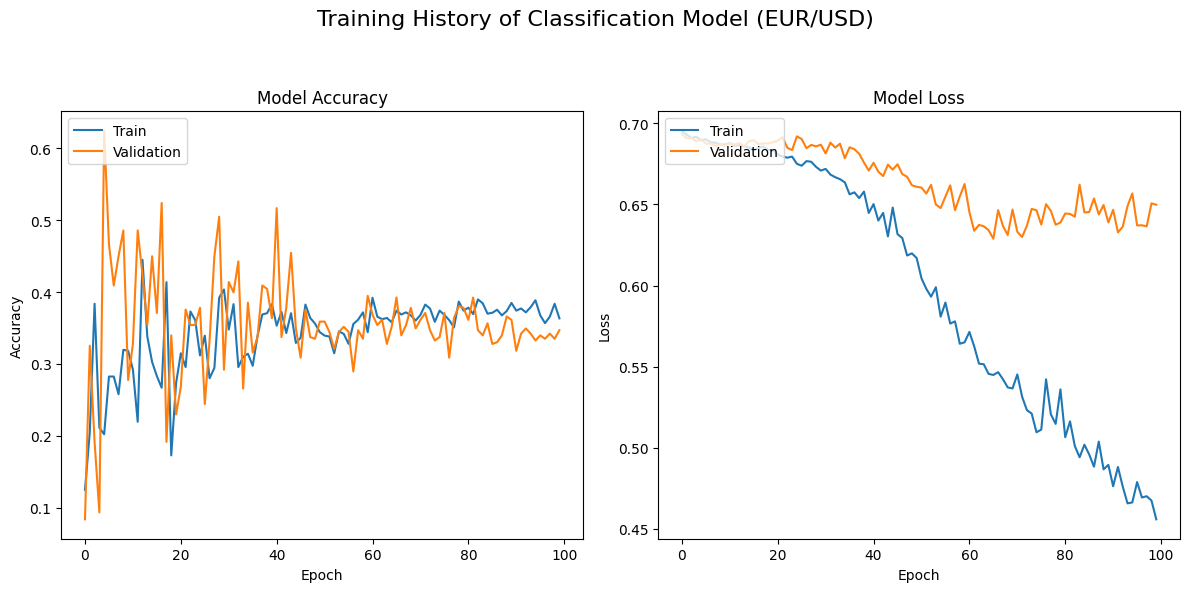

In [42]:
# Visualize training history (Classification Model)
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Tambahkan title utama
plt.suptitle('Training History of Classification Model (EUR/USD)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])  # beri ruang untuk suptitle
plt.show()


Grafik overfitting, namun yang digunakan adalah dari checkpoint best_model

### Save Model

In [25]:
# save model
model_cls.save('EURUSD_model_cls.h5')
# save scaler
joblib.dump(scaler, 'EURUSD_scaler.save')

['EURUSD_scaler.save']

## Regresi

### Split Data

In [26]:
# Split data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42, shuffle=False
    )


### Build Model

In [27]:
# Arsitektur model LSTM untuk regresi 5 output
model_reg = Sequential([
    LSTM(64, return_sequences=False, input_shape=(X_train_reg.shape[1], X_train_reg.shape[2])),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(5)  # Output untuk Close_t+1 hingga Close_t+5
])

model_reg.compile(optimizer='adam', loss='mse', metrics=['mae'])
model_reg.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 64)             │        21,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,493 (91.77 KB)

 Trainable params: 23,493 (91.77 KB)

 Non-trainable params: 0 (0.00 B)

### Train

In [28]:
# Checkpoint untuk menyimpan model terbaik
checkpoint_reg = ModelCheckpoint('best_model_reg.h5', monitor='val_loss', save_best_only=True, verbose=1)

history_reg = model_reg.fit(
    X_train_reg, y_train_reg,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[checkpoint_reg],
    verbose=1
)


Epoch 1/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5836 - mae: 0.6225
Epoch 1: val_loss improved from inf to 0.00445, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.5712 - mae: 0.6124 - val_loss: 0.0044 - val_mae: 0.0554
Epoch 2/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0243 - mae: 0.1248
Epoch 2: val_loss improved from 0.00445 to 0.00149, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0242 - mae: 0.1246 - val_loss: 0.0015 - val_mae: 0.0314
Epoch 3/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0160 - mae: 0.1004
Epoch 3: val_loss improved from 0.00149 to 0.00110, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.0159 - mae: 0.1003 - val_loss: 0.0011 - val_mae: 0.0266
Epoch 4/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0136 - mae: 0.0924
Epoch 4: val_loss did not improve from 0.00110
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0136 - mae: 0.0923 - val_loss: 0.0018 - val_mae: 0.0354
Epoch 5/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0110 - mae: 0.0825
Epoch 5: val_loss did not improve from 0.00110
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 0.0110 - mae: 0.0825 - val_loss: 0.0020 - val_mae: 0.0376
Epoch 6/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0098 - mae: 0.0778
Epoch 6: val_loss did not improve from 0.00110
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 0.0098 - mae: 0.0778 - val_loss: 0.0015 - val_mae: 0.0302
Epoch 7/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0083 - mae: 0.0727
Epoch 7: val_loss improved from 0.00110 to 0.00096, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0083 - mae: 0.0727 - val_loss: 9.6168e-04 - val_mae: 0.0240
Epoch 8/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0071 - mae: 0.0675
Epoch 8: val_loss did not improve from 0.00096
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0071 - mae: 0.0675 - val_loss: 0.0011 - val_mae: 0.0275
Epoch 9/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0074 - mae: 0.0689
Epoch 9: val_loss improved from 0.00096 to 0.00049, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0074 - mae: 0.0689 - val_loss: 4.8560e-04 - val_mae: 0.0171
Epoch 10/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0067 - mae: 0.0643
Epoch 10: val_loss did not improve from 0.00049
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0066 - mae: 0.0642 - val_loss: 8.1817e-04 - val_mae: 0.0240
Epoch 11/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0058 - mae: 0.0607
Epoch 11: val_loss did not improve from 0.00049
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0058 - mae: 0.0606 - val_loss: 0.0015 - val_mae: 0.0340
Epoch 12/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.0056 - mae: 0.0597
Epoch 12: val_loss did not improve from 0.00049
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0056 - mae: 0.0597 - val_loss: 0.0038 - val_mae: 0.0580
Epoch 13/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0060 - mae: 0.0614
Epoch 13: val_loss did not improve from 0.00049
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - loss: 0.0046 - mae: 0.0539 - val_loss: 4.5056e-04 - val_mae: 0.0163
Epoch 17/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0040 - mae: 0.0502
Epoch 17: val_loss improved from 0.00045 to 0.00041, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0040 - mae: 0.0503 - val_loss: 4.0943e-04 - val_mae: 0.0167
Epoch 18/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0041 - mae: 0.0511
Epoch 18: val_loss did not improve from 0.00041
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0041 - mae: 0.0511 - val_loss: 0.0010 - val_mae: 0.0282
Epoch 19/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0036 - mae: 0.0475
Epoch 19: val_loss did not improve from 0.00041
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 0.0036 - mae: 0.0475 - val_loss: 5.5902e-04 - val_mae: 0.0195
Epoch 20/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0036 - mae: 0.0477
Epoch 20: val_loss did not improve from 0.00041
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0036 - mae: 0.0477 - val_loss: 0.0015 - val_mae: 0.0361
Epoch 21/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0035 - mae: 0.0470
Epoch 21: val_loss did not improve from 0.00041
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0019 - mae: 0.0348 - val_loss: 2.6016e-04 - val_mae: 0.0127
Epoch 32/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0018 - mae: 0.0334
Epoch 32: val_loss did not improve from 0.00026
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0018 - mae: 0.0333 - val_loss: 3.6629e-04 - val_mae: 0.0154
Epoch 33/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0017 - mae: 0.0321
Epoch 33: val_loss did not improve from 0.00026
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 0.0017 - mae: 0.0321 - val_loss: 4.4937e-04 - val_mae: 0.0177
Epoch 34/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0015 - mae: 0.0300
Epoch 34: val_loss did not improve from 0.00026
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0015 - mae: 0.0300 - val_loss: 5.6694e-04 - val_mae: 0.0204
Epoch 35/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.0015 - mae: 0.0308
Epoch 35: val_loss did not improve from 0.00026
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step 

53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.0012 - mae: 0.0283 - val_loss: 1.9057e-04 - val_mae: 0.0106
Epoch 39/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0010 - mae: 0.0257
Epoch 39: val_loss improved from 0.00019 to 0.00019, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0010 - mae: 0.0257 - val_loss: 1.8984e-04 - val_mae: 0.0105
Epoch 40/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 9.9964e-04 - mae: 0.0253
Epoch 40: val_loss did not improve from 0.00019
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 9.9866e-04 - mae: 0.0253 - val_loss: 2.0930e-04 - val_mae: 0.0112
Epoch 41/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 9.3519e-04 - mae: 0.0239
Epoch 41: val_loss did not improve from 0.00019
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 9.3550e-04 - mae: 0.0239 - val_loss: 2.7521e-04 - val_mae: 0.0133
Epoch 42/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 8.4670e-04 - mae: 0.0230
Epoch 42: val_loss did not improve from 0.00019
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 8.4529e-04 - mae: 0.0230 - val_loss: 3.9082e-04 - val_mae: 0.0165
Epoch 43/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 6.6336e-04 - mae: 0.0203
Epoch 43: val_loss did not improve from 0.00019
53/53 ━━━━━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 3.5220e-04 - mae: 0.0147 - val_loss: 1.8407e-04 - val_mae: 0.0103
Epoch 52/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3.1561e-04 - mae: 0.0141
Epoch 52: val_loss improved from 0.00018 to 0.00018, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 3.1568e-04 - mae: 0.0141 - val_loss: 1.8083e-04 - val_mae: 0.0102
Epoch 53/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 3.0648e-04 - mae: 0.0140
Epoch 53: val_loss did not improve from 0.00018
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 3.0644e-04 - mae: 0.0140 - val_loss: 3.8868e-04 - val_mae: 0.0165
Epoch 54/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 3.2248e-04 - mae: 0.0139
Epoch 54: val_loss did not improve from 0.00018
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 3.2212e-04 - mae: 0.0139 - val_loss: 2.1115e-04 - val_mae: 0.0111
Epoch 55/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 2.5492e-04 - mae: 0.0125
Epoch 55: val_loss improved from 0.00018 to 0.00017, saving model to best_model_reg.h5


53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 2.5522e-04 - mae: 0.0125 - val_loss: 1.7155e-04 - val_mae: 0.0100
Epoch 56/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.7739e-04 - mae: 0.0132
Epoch 56: val_loss did not improve from 0.00017
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 2.7728e-04 - mae: 0.0132 - val_loss: 2.1511e-04 - val_mae: 0.0116
Epoch 57/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.5664e-04 - mae: 0.0125
Epoch 57: val_loss did not improve from 0.00017
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 2.5649e-04 - mae: 0.0125 - val_loss: 1.7705e-04 - val_mae: 0.0101
Epoch 58/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 2.1861e-04 - mae: 0.0117
Epoch 58: val_loss did not improve from 0.00017
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 2.1860e-04 - mae: 0.0117 - val_loss: 1.7962e-04 - val_mae: 0.0103
Epoch 59/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 2.3675e-04 - mae: 0.0122
Epoch 59: val_loss did not improve from 0.00017
53/53 ━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 2.1051e-04 - mae: 0.0115 - val_loss: 1.6709e-04 - val_mae: 0.0098
Epoch 68/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.8534e-04 - mae: 0.0107
Epoch 68: val_loss did not improve from 0.00017
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 1.8520e-04 - mae: 0.0107 - val_loss: 1.7368e-04 - val_mae: 0.0100
Epoch 69/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.9354e-04 - mae: 0.0110
Epoch 69: val_loss did not improve from 0.00017
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 1.9345e-04 - mae: 0.0109 - val_loss: 2.1771e-04 - val_mae: 0.0114
Epoch 70/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.7374e-04 - mae: 0.0102
Epoch 70: val_loss did not improve from 0.00017
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - loss: 1.7359e-04 - mae: 0.0102 - val_loss: 1.9449e-04 - val_mae: 0.0107
Epoch 71/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 1.6523e-04 - mae: 0.0100
Epoch 71: val_loss did not improve from 0.00017
53/53 ━━

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 1.4345e-04 - mae: 0.0093 - val_loss: 1.5934e-04 - val_mae: 0.0097
Epoch 93/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.4757e-04 - mae: 0.0095
Epoch 93: val_loss did not improve from 0.00016
53/53 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 1.4749e-04 - mae: 0.0095 - val_loss: 1.8712e-04 - val_mae: 0.0106
Epoch 94/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.4881e-04 - mae: 0.0095
Epoch 94: val_loss did not improve from 0.00016
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 1.4865e-04 - mae: 0.0095 - val_loss: 1.7273e-04 - val_mae: 0.0101
Epoch 95/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.3759e-04 - mae: 0.0092
Epoch 95: val_loss did not improve from 0.00016
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 1.3770e-04 - mae: 0.0092 - val_loss: 2.8944e-04 - val_mae: 0.0135
Epoch 96/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 1.6818e-04 - mae: 0.0101
Epoch 96: val_loss improved from 0.00016 to 0.00015, sav

53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 1.6784e-04 - mae: 0.0100 - val_loss: 1.4814e-04 - val_mae: 0.0092
Epoch 97/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1.3711e-04 - mae: 0.0091
Epoch 97: val_loss did not improve from 0.00015
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 1.3717e-04 - mae: 0.0091 - val_loss: 1.6970e-04 - val_mae: 0.0098
Epoch 98/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 1.4470e-04 - mae: 0.0094
Epoch 98: val_loss did not improve from 0.00015
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 1.4475e-04 - mae: 0.0094 - val_loss: 2.4775e-04 - val_mae: 0.0128
Epoch 99/100
52/53 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.7214e-04 - mae: 0.0103
Epoch 99: val_loss did not improve from 0.00015
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 1.7143e-04 - mae: 0.0103 - val_loss: 1.5011e-04 - val_mae: 0.0092
Epoch 100/100
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1.5278e-04 - mae: 0.0096
Epoch 100: val_loss did not improve from 0.00015
53/53 

### Evaluation

17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 8.7722e-05 - mae: 0.0071
Test Loss (MSE): 0.000101, Test MAE: 0.007523
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


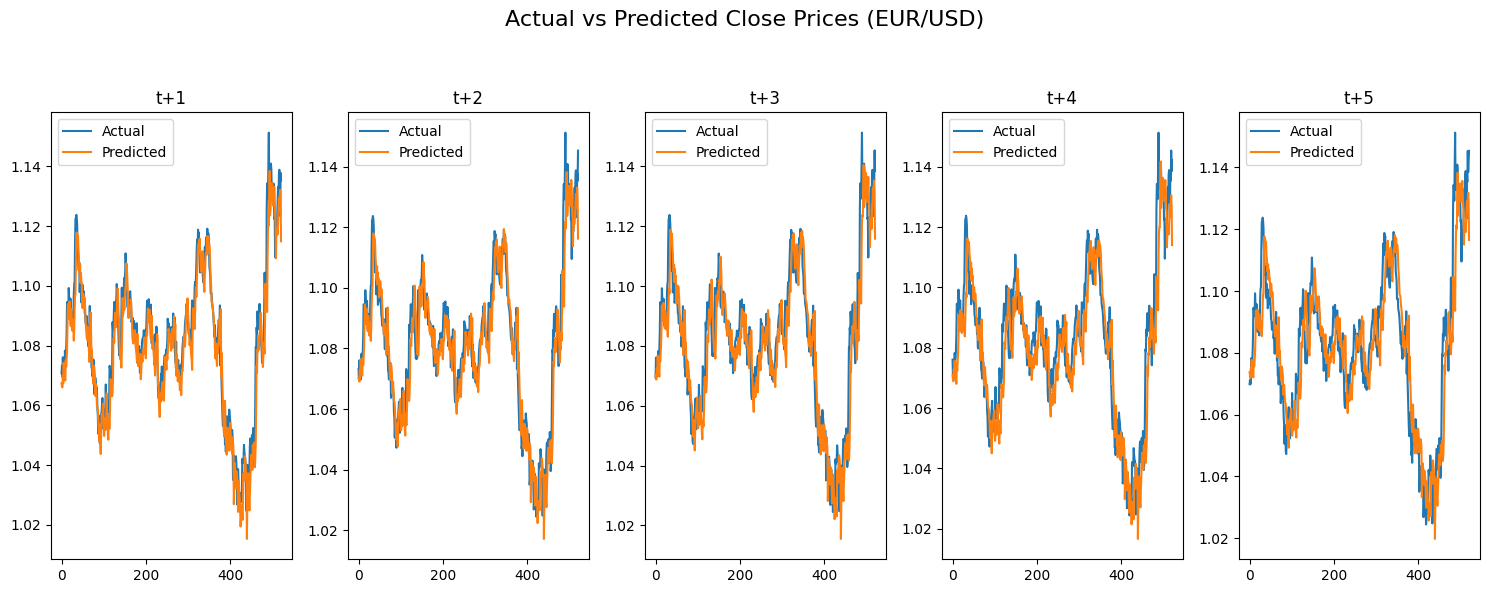

In [36]:
# Evaluasi
loss, mae = model_reg.evaluate(X_test_reg, y_test_reg)
print(f"Test Loss (MSE): {loss:.6f}, Test MAE: {mae:.6f}")

# Plot prediksi vs aktual
y_pred_reg = model_reg.predict(X_test_reg)

plt.figure(figsize=(15, 6))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.plot(y_test_reg[:, i], label='Actual')
    plt.plot(y_pred_reg[:, i], label='Predicted')
    plt.title(f"t+{i+1}")  # judul untuk masing-masing subplot
    plt.legend()

plt.suptitle("Actual vs Predicted Close Prices (EUR/USD)", fontsize=16)  # satu judul utama
plt.tight_layout(rect=[0, 0, 1, 0.93])  # agar tidak menabrak suptitle
plt.show()


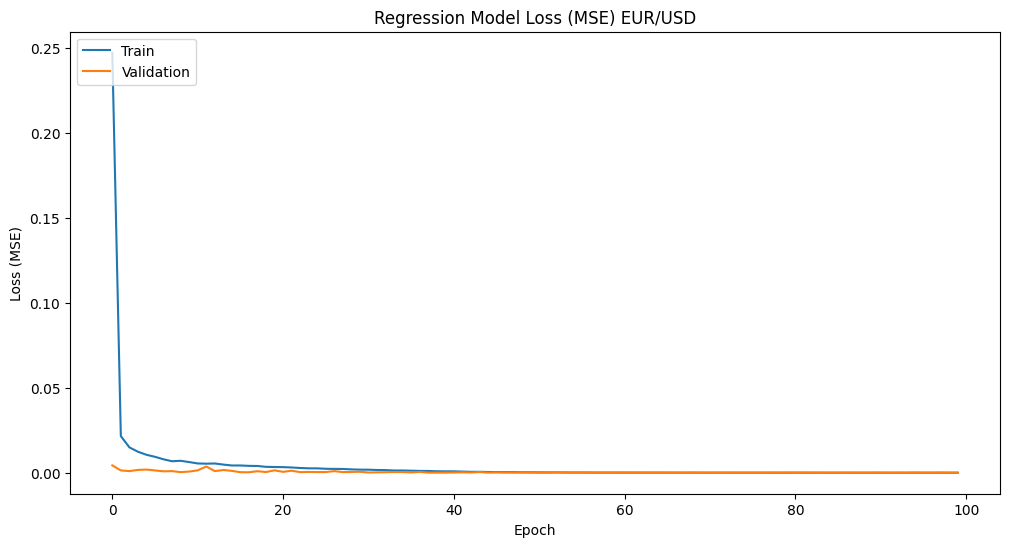

In [41]:
# Visualize training history (Regression Model)
plt.figure(figsize=(12, 6))

# Plot training & validation loss values for regression
plt.plot(history_reg.history['loss'])
plt.plot(history_reg.history['val_loss'])
plt.title('Regression Model Loss (MSE) EUR/USD')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

### Save Model

In [38]:
# Save model regresi
model_reg.save('EURUSD_model_reg.h5')

# Inferensi

In [39]:
# Ambil window terakhir dari array features yang sudah disiapkan sebelumnya
latest_sequence = features[-window_size:]  # Shape (90, features)

# Ubah ke bentuk batch
X_latest = np.expand_dims(latest_sequence, axis=0).astype(np.float32)

# Get the last actual close price BEFORE scaling
last_actual_close = data['Close'].iloc[-window_size - 1] # Get the close price from the row *before* the latest sequence starts

# Prediksi probabilitas naik (tetap menggunakan model_cls)
y_pred_probs_cls = model_cls.predict(X_latest)
y_pred_cls = (y_pred_probs_cls > 0.5).astype(int)

# Prediksi harga penutupan (scaled, tetap menggunakan model_reg)
y_pred_price_scaled = model_reg.predict(X_latest)

# Kembalikan skala harga ke bentuk aslinya
close_min = scaler.data_min_[0]
close_max = scaler.data_max_[0]

# Function to inverse transform manual only for the Close column
def inverse_minmax(value, vmin, vmax):
    return value * (vmax - vmin) + vmin - 0.147

predicted_actual_prices = []
results = []
reference_price = last_actual_close # Start with the last actual close as the reference for t+1

print("📊 Prediksi Klasifikasi (Naik/Turun Relative to Previous Day's Predicted Close):")
print("📈 Prediksi Harga Penutupan (Close) Pekan Depan:")

for i in range(5):
    # Inverse transform the predicted scaled price for the current day (t+i+1)
    predicted_scaled_price = y_pred_price_scaled[0, i]
    predicted_original_price_absolute = inverse_minmax(predicted_scaled_price, close_min, close_max)

    # Determine classification relative to the reference price (previous day's close or predicted close)
    classification = "Naik" if predicted_original_price_absolute > reference_price else "Turun"

    print(f"t+{i+1}: {classification} (Probabilitas: {y_pred_probs_cls[0, i]:.2f}), Prediksi Harga: {predicted_original_price_absolute:.5f}")

    result = {
        f"t+{i+1}": {
            "classification": classification,
            "classification_probability": float(y_pred_probs_cls[0, i]),
            "predicted_close_price": float(predicted_original_price_absolute)
        }
    }
    results.append(result)

    # Update the reference price for the next iteration
    reference_price = predicted_original_price_absolute


# Menyimpan hasil ke file JSON
output_filename = "EURUSD_prediksi.json"
with open(output_filename, 'w') as f:
    json.dump(results, f, indent=4)

print(f"\nHasil prediksi klasifikasi dan harga telah disimpan ke {output_filename}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
📊 Prediksi Klasifikasi (Naik/Turun Relative to Previous Day's Predicted Close):
📈 Prediksi Harga Penutupan (Close) Pekan Depan:
t+1: Naik (Probabilitas: 0.66), Prediksi Harga: 1.14175
t+2: Turun (Probabilitas: 0.89), Prediksi Harga: 1.14175
t+3: Turun (Probabilitas: 0.95), Prediksi Harga: 1.14167
t+4: Turun (Probabilitas: 0.97), Prediksi Harga: 1.14149
t+5: Naik (Probabilitas: 0.98), Prediksi Harga: 1.14192

Hasil prediksi klasifikasi dan harga telah disimpan ke EURUSD_prediksi.json
